# 1)      Валідація двох альтернатив: additive VS multiplicative;

2)      Описова частина (Moving Average, Exponential Smoothing, Differencing, Stationarity);

3)      Валідація двох альтернатив приведення до стаціонарного ряду: decomposition VS differencing;

4)      Тренування та валідація MA, AR, ARMA, ARIMA моделей;

5)      Генерація фіч та валідація ML моделей (тут на Ваш смак будь-які з відомих регресивних моделей). Буде вважатися плюсом додавання додаткових екзогенних факторів, таких як опади, площі і тп.

6)      Висновки щодо того, яку модель краще використовувати;

7)      Прогноз на наступний рік

8)      На основі одержаного прогнозу планування ресурсів на наступний рік, використовуючи додаткову інформацію:

# Initialise environment

In [1]:
import numpy as np
import pandas as pd
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.dpi']= 100
matplotlib.rcParams['figure.figsize'] = 15, 5

# reading data from files 

In [2]:
REGION =   ['PRK', 'Perak', 'PRK'] # <==== variant = ...30 % 7 = 2, selecting third region 

In [3]:
production = pd.read_csv('data/production_good.csv')
rainfall = pd.read_csv('data/rainfall_good.csv')
area = pd.read_csv('data/area_good.csv')

In [4]:
production.head()

,index,Region,Year,Month,Production,Diff_production
0,0,JH,1998,1,118.359,0.000
1,1,JH,1998,2,147.988,0.000
2,2,JH,1998,3,145.514,29.629
3,3,JH,1998,4,154.638,-2.474
4,4,JH,1998,5,155.827,9.124


In [5]:
rainfall.head()

,Region,Year,Month,Rainfall
0,Johor,1980,1,254.566667
1,Johor,1981,1,67.500000
2,Johor,1982,1,124.833333
3,Johor,1983,1,149.866667
4,Johor,1984,1,446.900000


In [6]:
area.head()

,Area_New,Area_ma,Area_ma_new,Area_npa,Area_rpa,Region,Year
0,0.0,0.0,0.000000,0.0,0.0,JH,1974
1,59.0,128.0,128.000000,187.0,0.0,JH,1975
2,59.0,147.0,147.000000,206.0,0.0,JH,1976
3,56.0,171.0,116.538462,227.0,0.0,JH,1977
4,59.0,191.0,93.423077,250.0,0.0,JH,1978


In [7]:
RAINFALL_LAGS = [6, 7, 8, 9, 10, 11, 12]
PRODUCTION_LAGS = [6, 7, 8, 9, 10, 11, 12]

In [8]:
def process_data(production, rainfall, area, region, PRODUCTION_LAGS, RAINFALL_LAGS):
    data = production[production.Region == region[0]]
    data = pd.merge(data[['Year', 'Month', 'Production', 'Diff_production']],
                    rainfall[rainfall.Region == region[1]][['Year', 'Month', 'Rainfall']], 
                    on=['Year', 'Month'], how='left')

    data = pd.merge(data, area[area.Region == region[2]][
        ['Year', 'Area_ma', 'Area_npa', 'Area_rpa', 'Area_New', 'Area_ma_new']], on='Year', how='left')

    data['Year'] = data['Year'].astype(int)
    data['Month'] = data['Month'].astype(int)
    data.reset_index(inplace=True)

    data.set_index([pd.to_datetime(['{0}-{1}-01'.format(x, y) for (x, y) in zip(data.Year, data.Month)])],
                   inplace=True)

    data.drop(['index', 'Year', 'Area_New', 'Diff_production'], axis=1, inplace=True)
    data['Time'] = np.arange(len(data))

    for lag in RAINFALL_LAGS:
        temp = np.concatenate((np.array([np.nan for _ in range(lag)]), data.Rainfall.values[:-lag]))
        data['Rainfall_{0}'.format(lag)] = temp

    for lag in PRODUCTION_LAGS:
        temp = np.concatenate((np.array([np.nan for _ in range(lag)]), data.Production.values[:-lag]))
        data['Production_{0}'.format(lag)] = temp

    PRODUCTION = data.Production
    data.drop(['Production'], axis=1, inplace=True)

    data.fillna(data.mean(), inplace=True)

    #  And finally drop rainfalls
    data.drop(['Rainfall'], axis=1, inplace=True)
    ### HERE I CAN ADD FEATURE ENGINEERING!!!

    #  And clip first year
    for col in data.columns:
        data['_'.join([region[1], str(col)])] = data[col]
        data.drop([col], axis=1, inplace=True)
        
    return (data[max(PRODUCTION_LAGS):], PRODUCTION[max(PRODUCTION_LAGS):])


In [9]:
#Read down variant
DATA = process_data(production, rainfall, area, REGION, PRODUCTION_LAGS, RAINFALL_LAGS)

In [10]:
DATA[0].head()

,Perak_Month,Perak_Area_ma,Perak_Area_npa,Perak_Area_rpa,Perak_Area_ma_new,Perak_Time,Perak_Rainfall_6,Perak_Rainfall_7,Perak_Rainfall_8,Perak_Rainfall_9,Perak_Rainfall_10,Perak_Rainfall_11,Perak_Rainfall_12,Perak_Production_6,Perak_Production_7,Perak_Production_8,Perak_Production_9,Perak_Production_10,Perak_Production_11,Perak_Production_12
1999-01-01,1,262.0,303.0,2.0,143.3,12,139.76,85.43,217.63,99.72,77.90,57.48,109.84,102.732,92.812,83.162,75.789,76.202,75.258,64.054
1999-02-01,2,262.0,303.0,2.0,143.3,13,183.15,139.76,85.43,217.63,99.72,77.90,57.48,104.759,102.732,92.812,83.162,75.789,76.202,75.258
1999-03-01,3,262.0,303.0,2.0,143.3,14,139.21,183.15,139.76,85.43,217.63,99.72,77.90,95.395,104.759,102.732,92.812,83.162,75.789,76.202
1999-04-01,4,262.0,303.0,2.0,143.3,15,224.90,139.21,183.15,139.76,85.43,217.63,99.72,82.394,95.395,104.759,102.732,92.812,83.162,75.789
1999-05-01,5,262.0,303.0,2.0,143.3,16,278.00,224.90,139.21,183.15,139.76,85.43,217.63,74.966,82.394,95.395,104.759,102.732,92.812,83.162


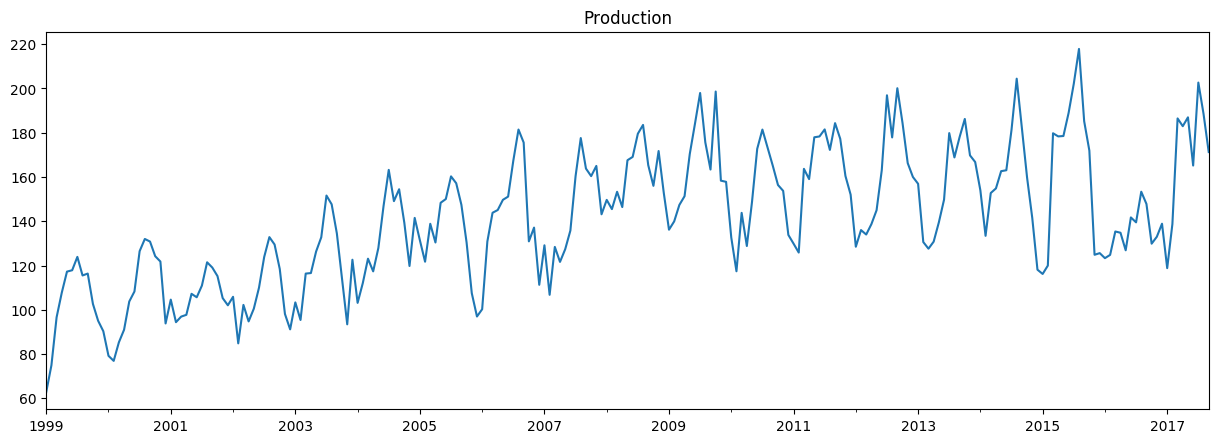

In [11]:
raw_ts = DATA[1]
raw_ts.plot(title = 'Production')

# 1)      Валідація двох альтернатив: additive VS multiplicative;
If the TS has multiplicative nature we can explect the growth in amplitude of values during period (it is explained with propperty that change of magnitude in one variable of product (Seson*Trend*Residuals) will affect resulting data. We can observe it like increase or decrease of seasonal oscilations. 
Therefore check those properties between first and last quarters:

## presume that whe know appropriate seasonality (we know that crop cycle is 1 year)

In [12]:
CYCLE = 12

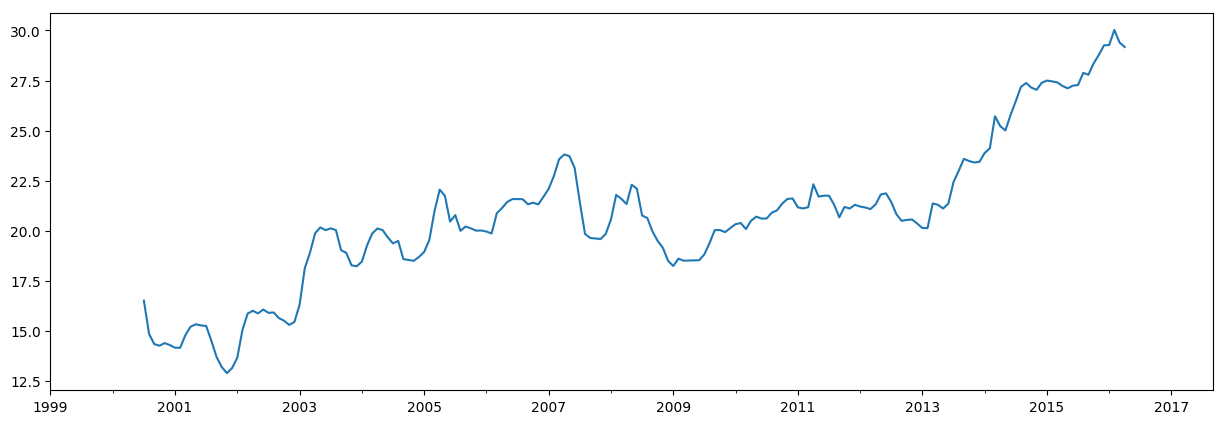

In [13]:
raw_ts.rolling(3*CYCLE, center=True).std().plot()

In [14]:
#can't use pdp on default 
def my_centered_roll (window_size, data, np_function,step):
    spans = []
    side_offset = window_size // 2
    
    start = 0
    end = start + window_size
    while end < len(data):
        piece = data[start:end]
        spans.append(np_function(piece))
        end+=step
        start+=step
    return spans

In [15]:
pdps = my_centered_roll(3*CYCLE, raw_ts, np.ptp, CYCLE)
print(np.mean(pdps))

80.827


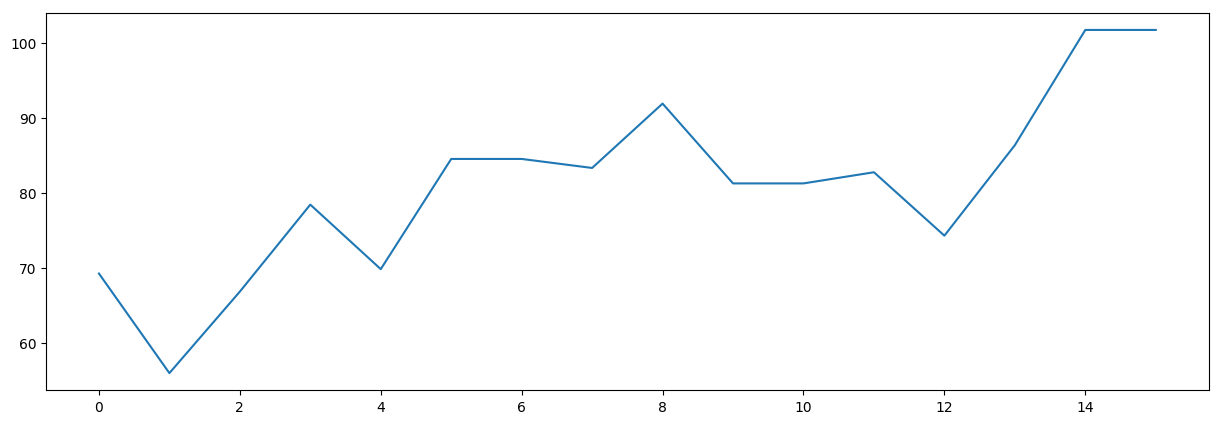

In [16]:
plt.plot(pdps)

As we observe, there is increase in magnitude of data, therefore process migh be multiplicative. 
To avoid possible problems log it's values

In [17]:
ts_log = np.log (raw_ts)

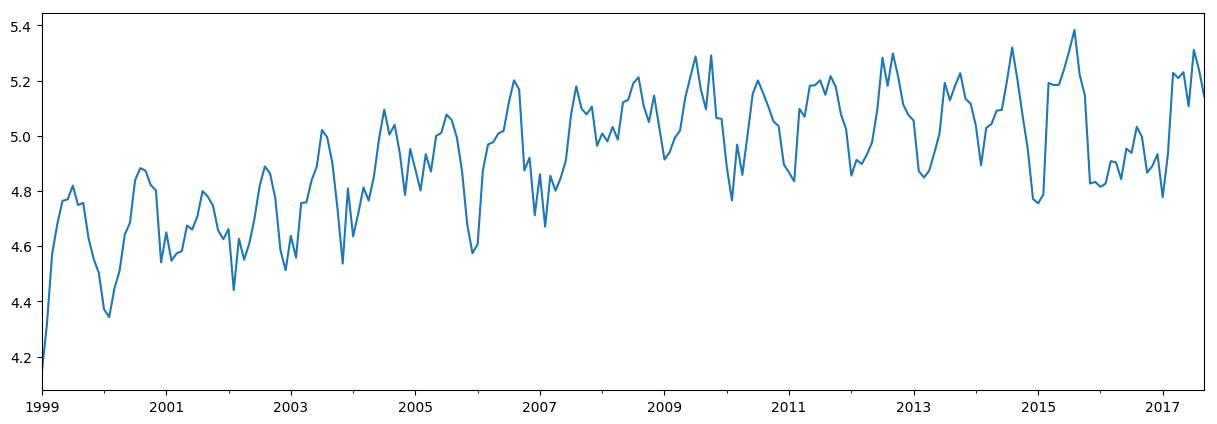

In [18]:
ts_log.plot()

0.588473947374


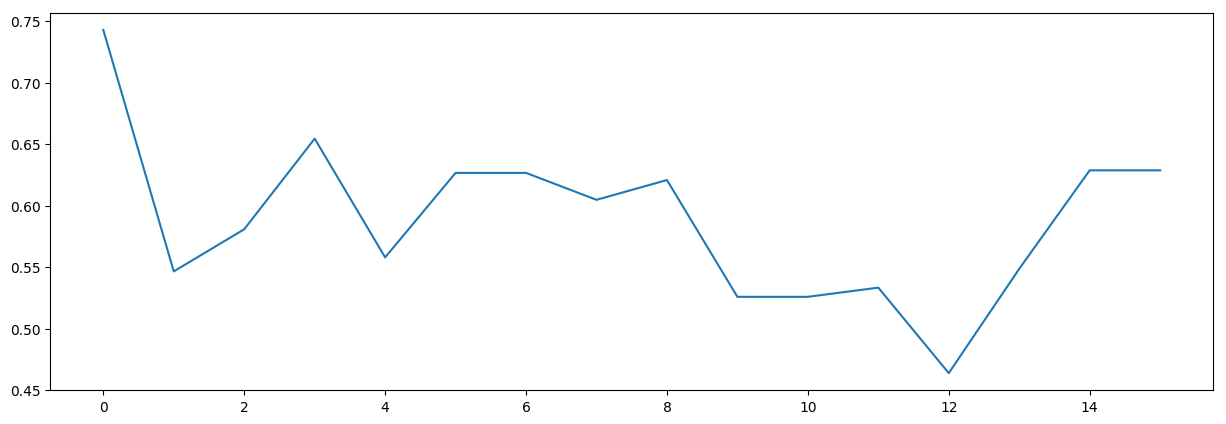

In [19]:
log_pdps = my_centered_roll(3*CYCLE, ts_log, np.ptp, CYCLE)
print(np.mean(log_pdps))
plt.plot(log_pdps)

 ## As we see oscilations amplitude decreased dramatically and become zero-centered, assume hypothesis of multiplicative nature of data confirmed.

# 2) Описова частина (Moving Average, Exponential Smoothing, Differencing, Stationarity);

# Stationarity 
we will use Dickey-Fuller test to determine is there left significant time-dependand part in our data

In [20]:
from statsmodels.tsa.stattools import adfuller
def stationarity_test(ts):
    
    rolmean = ts.rolling(12).mean()
    rolstd = ts.rolling(12).std()

    orig = plt.plot(ts, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')

    # Dickey-Fuller test:
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(ts, autolag='AIC')
    print(dftest)     
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)    

/usr/local/lib/python3.5/dist-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


### As expected we obtain large p-value () , and statistics value significantly larger then critical values for 10%, 5%, 1% probability to reject hypothesis of non-stationarity.

Results of Dickey-Fuller Test:
(-1.7426388634344894, 0.40928826422452763, 12, 212, {'10%': -2.5740891037735847, '5%': -2.8752718989837249, '1%': -3.4615775784078466}, -387.566920415705)
Test Statistic                  -1.742639
p-value                          0.409288
#Lags Used                      12.000000
Number of Observations Used    212.000000
Critical Value (10%)            -2.574089
Critical Value (5%)             -2.875272
Critical Value (1%)             -3.461578
dtype: float64


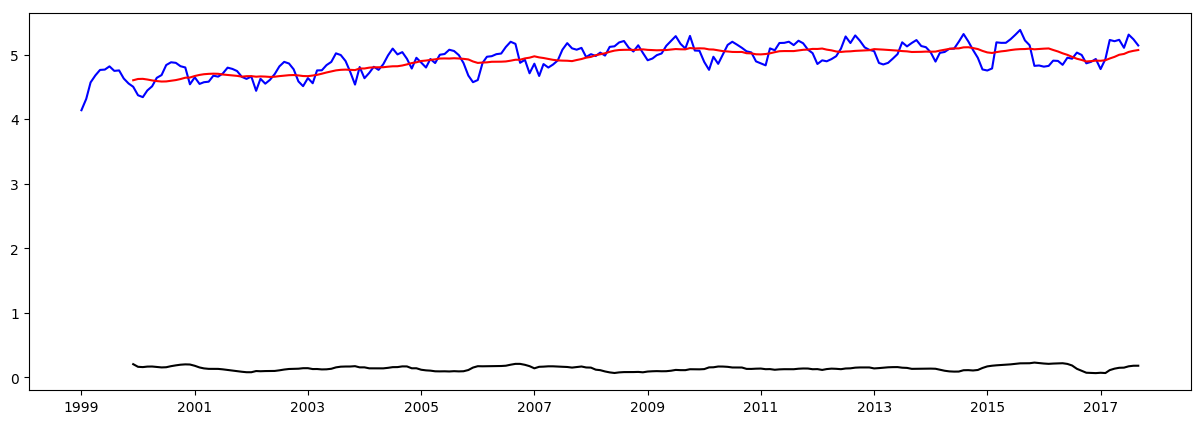

In [21]:
stationarity_test(ts_log)

# Moving avarage analysys
This kind of analysys gives us estimation of general trend over our dataset, as we see, 3 cycles are generally enought for avoding seasonal oscilations

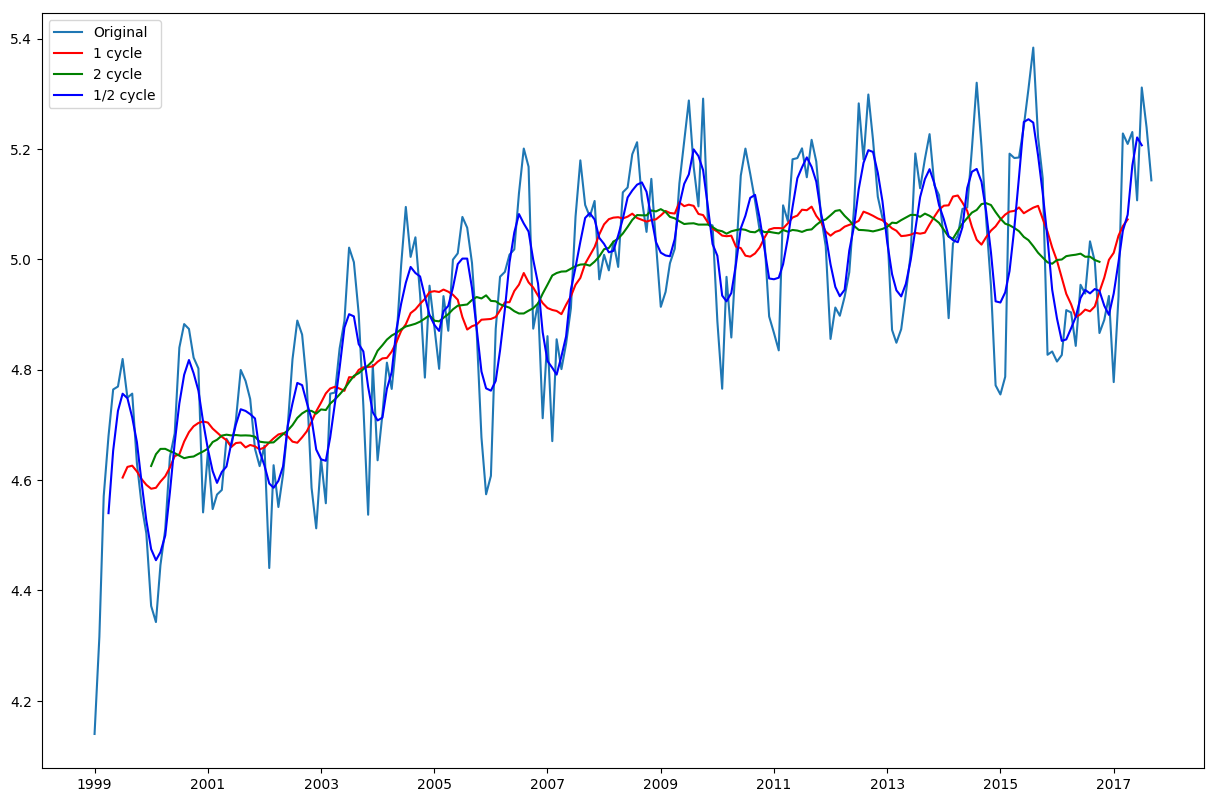

In [22]:
ts_moving_avg_center1 = ts_log.rolling(CYCLE, center=True).mean()
ts_moving_avg_center1.dropna(inplace=True)
# ts_moving_avg_center1.fillna(method='ffill', inplace=True)

ts_moving_avg_center2 = ts_log.rolling(2*CYCLE, center=True).mean()
ts_moving_avg_center2.dropna(inplace=True)
# ts_moving_avg_center2.fillna(method='ffill', inplace=True)


ts_moving_avg_center05 = ts_log.rolling(CYCLE//2, center=True).mean()
ts_moving_avg_center05.dropna(inplace=True)
# ts_moving_avg_center05.fillna(method='ffill', inplace=True)
matplotlib.rcParams['figure.figsize'] = 15, 10
plt_original, = plt.plot(ts_log, )
plt_1cycle, =plt.plot(ts_moving_avg_center1, color='red')
plt_2cycle, =plt.plot(ts_moving_avg_center2, color='green')
plt_0_5cycle, =plt.plot(ts_moving_avg_center05, color='blue')
plt.legend(
    [plt_original, plt_1cycle, plt_2cycle,  plt_0_5cycle],
           ['Original', '1 cycle', '2 cycle', '1/2 cycle']
)
matplotlib.rcParams['figure.figsize'] = 15, 5

## Detrended data (shocks)

In [23]:
print(ts_log.mean())
print ("Original Mean=[{}]   STD= [{}]  PTP = [{}] ".format(
    (ts_log  ).mean(),
    (ts_log  ).std(),
    (ts_log  ).ptp()
)) 
log_dif_cycle1 = ts_log - ts_moving_avg_center1
log_dif_cycle1.dropna(inplace= True)
print ("1 cycle Mean=[{}]   STD= [{}]   PTP = [{}]".format(  
    log_dif_cycle1.mean(),
    log_dif_cycle1.std(),
    log_dif_cycle1.ptp())
)
log_dif_cycle2 = ts_log - ts_moving_avg_center2
log_dif_cycle2.dropna(inplace= True)
print ("2 cycle Mean=[{}]   STD= [{}]   PTP = [{}]".format( 
    log_dif_cycle2.mean(),
    log_dif_cycle2.std(),
    log_dif_cycle2.ptp())
)

log_dif_cycle05 = ts_log - ts_moving_avg_center05
log_dif_cycle05.dropna(inplace= True)
print ("1/2 cycle Mean=[{}]   STD= [{}]   PTP = [{}]".format( # < === severe lost of variance
    log_dif_cycle05.mean(),
    log_dif_cycle05.std(),
    log_dif_cycle05.ptp())
)


4.92600557495
Original Mean=[4.926005574952578]   STD= [0.22294049966092713]  PTP = [1.2440068973621905] 
1 cycle Mean=[0.0006300926280265633]   STD= [0.13497912126105852]   PTP = [0.6072318423428156]
2 cycle Mean=[-0.0019250163443965938]   STD= [0.14432846314152925]   PTP = [0.7203854100132201]
1/2 cycle Mean=[0.002574145739884076]   STD= [0.08100984017748851]   PTP = [0.44434233684697233]


## clearify what type of MA trend is the best with test

Results of Dickey-Fuller Test:
(-6.8522190699185082, 1.682955507028743e-09, 12, 201, {'10%': -2.5744932593252643, '5%': -2.8760293320457442, '1%': -3.4633090972761744}, -443.48427840333693)
Test Statistic                -6.852219e+00
p-value                        1.682956e-09
#Lags Used                     1.200000e+01
Number of Observations Used    2.010000e+02
Critical Value (10%)          -2.574493e+00
Critical Value (5%)           -2.876029e+00
Critical Value (1%)           -3.463309e+00
dtype: float64
Results of Dickey-Fuller Test:
(-6.4267723750802155, 1.7367310038055803e-08, 14, 187, {'10%': -2.5750770662586864, '5%': -2.8771233514726489, '1%': -3.465811691080702}, -391.14096292264298)
Test Statistic                -6.426772e+00
p-value                        1.736731e-08
#Lags Used                     1.400000e+01
Number of Observations Used    1.870000e+02
Critical Value (10%)          -2.575077e+00
Critical Value (5%)           -2.877123e+00
Critical Value (1%)           -3.

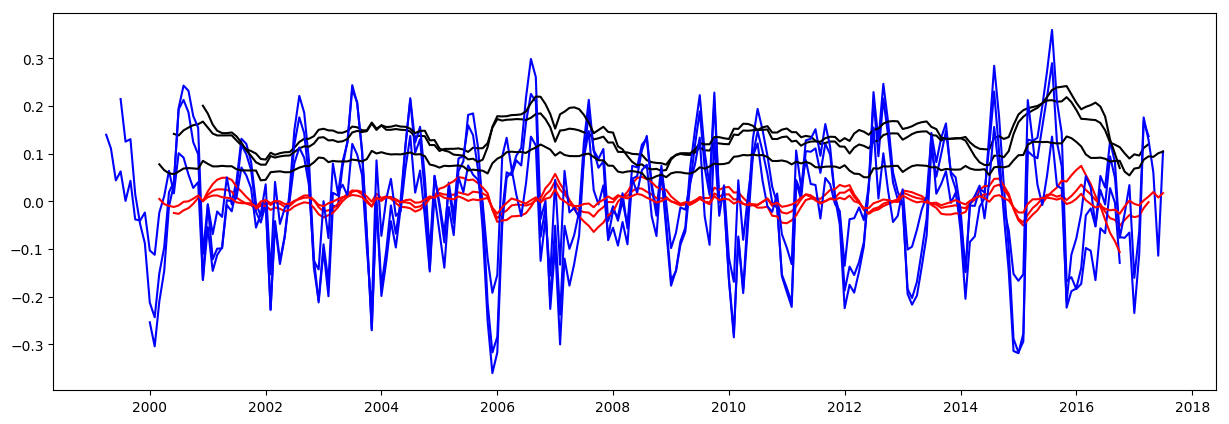

In [24]:
stationarity_test(log_dif_cycle1)
stationarity_test(log_dif_cycle2)
stationarity_test(log_dif_cycle05)

##  As 1/2 cycle MA allso gets away part of seasonality,  we see that best detrending occures when we are taking 1-cycled intervals in consiveration

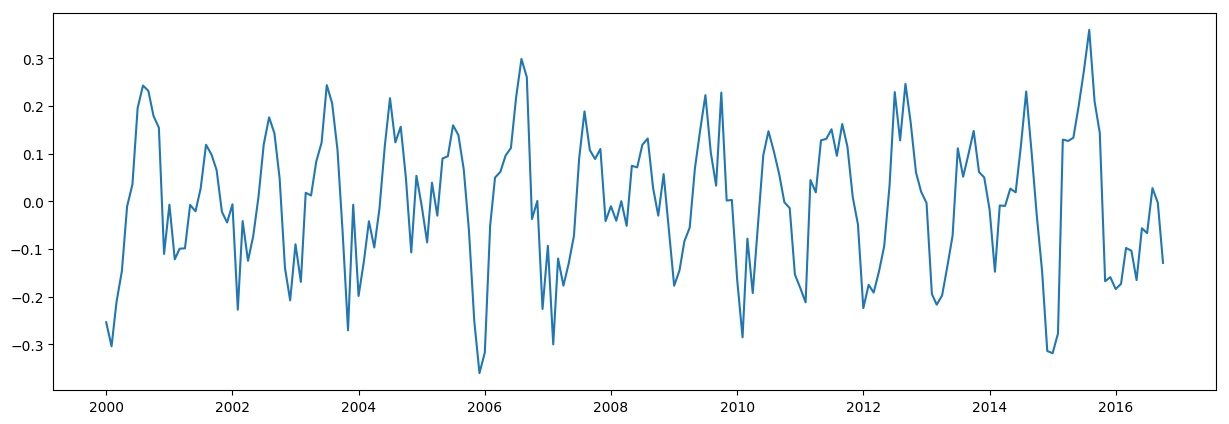

In [25]:
ts_detrended_MA = ts_log - ts_moving_avg_center2
plt.plot(ts_detrended_MA)

### As we observe that best centered result were obtained with approximation equalt to 1 Cycle, we can assume that our hypothesis about cycle length is valid.

# Exponential Smoothing
### This analysys type used for approximations of ts, reconstruction and short-term predictions of TS, main feature is that we use 'weighed' sum of a series episodes, usually giving more weight to closer episodes then to decent ones (in real TS close episodes have bigger autocorrelation). Allso it is good because we preserve all data period (tail and head of TS)

/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:1: FutureWarning: pd.ewm_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.ewm(adjust=True,min_periods=0,ignore_na=False,halflife=12).mean()
  if __name__ == '__main__':


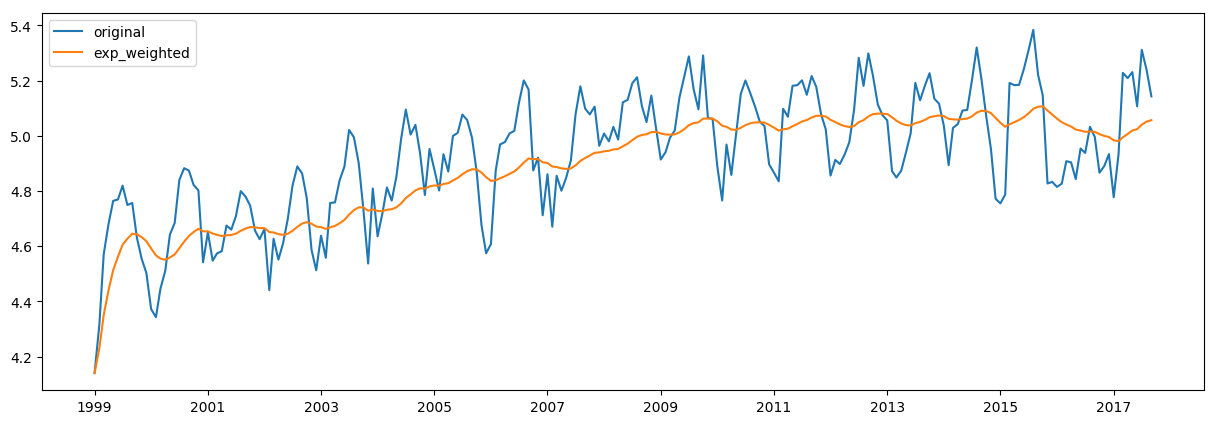

In [26]:
expwighted_avg = pd.ewma(ts_log, halflife=CYCLE)
orig, = plt.plot (ts_log)
exp_w, = plt.plot(expwighted_avg)
plt.legend(
    [orig, exp_w],
    ['original', 'exp_weighted']
)

0.037611011276
0.143858616472
0.613764737559


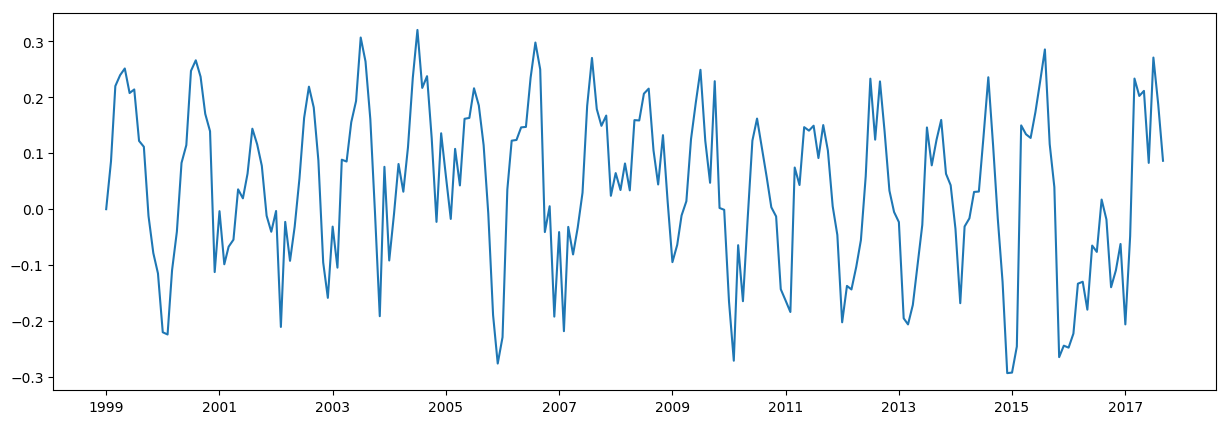

In [27]:
exp_detrended = ts_log - expwighted_avg
plt.plot(exp_detrended)
print (np.mean(exp_detrended))
print (np.std(exp_detrended) )
print (np.ptp(exp_detrended) )

Results of Dickey-Fuller Test:
(-3.7770398252581145, 0.0031511596057393989, 12, 212, {'10%': -2.5740891037735847, '5%': -2.8752718989837249, '1%': -3.4615775784078466}, -412.06599241678782)
Test Statistic                  -3.777040
p-value                          0.003151
#Lags Used                      12.000000
Number of Observations Used    212.000000
Critical Value (10%)            -2.574089
Critical Value (5%)             -2.875272
Critical Value (1%)             -3.461578
dtype: float64


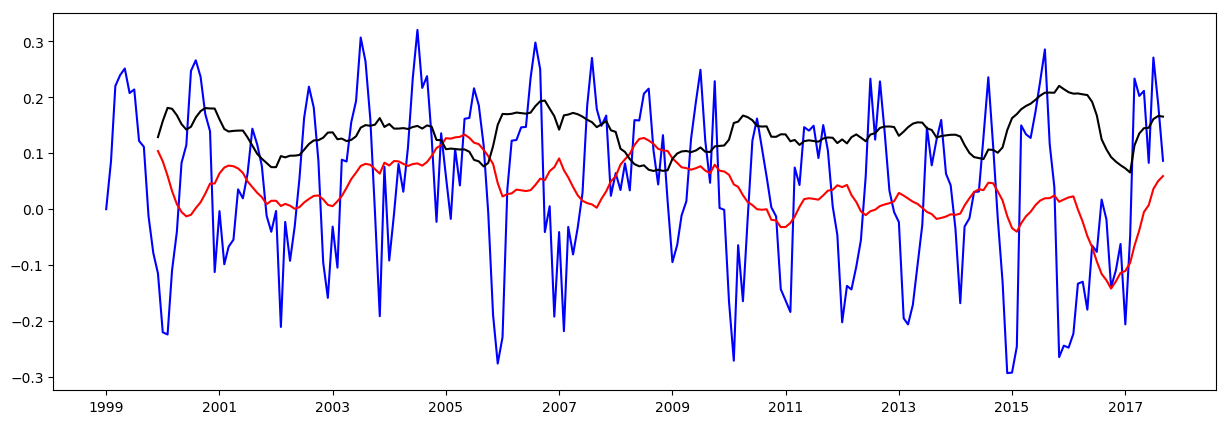

In [28]:
stationarity_test(exp_detrended)

# Differencing
We can apply this method to state what parameter d we have to use as ARIMA parameter to obtain stationarity of a model

Results of Dickey-Fuller Test:
(-6.1757135995404351, 6.6385185849765202e-08, 11, 212, {'10%': -2.5740891037735847, '5%': -2.8752718989837249, '1%': -3.4615775784078466}, -381.75496846355566)
Test Statistic                -6.175714e+00
p-value                        6.638519e-08
#Lags Used                     1.100000e+01
Number of Observations Used    2.120000e+02
Critical Value (10%)          -2.574089e+00
Critical Value (5%)           -2.875272e+00
Critical Value (1%)           -3.461578e+00
dtype: float64


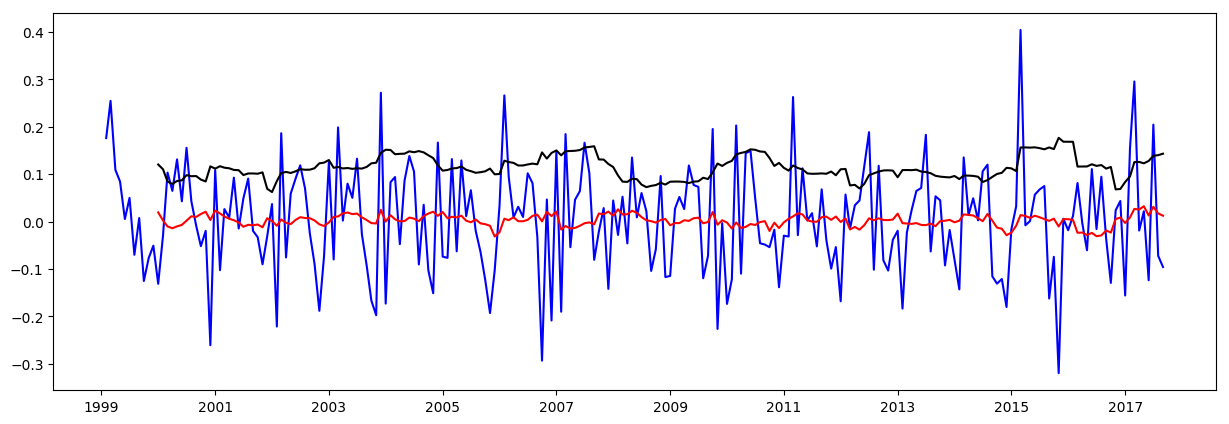

In [40]:
ts_log_diff1Auto = ts_log.diff()
ts_log_diff1Auto.dropna(inplace=True)
stationarity_test(ts_log_diff1Auto)

Results of Dickey-Fuller Test:
(-11.852268124183929, 7.1621084988571542e-22, 11, 211, {'10%': -2.5741240890815571, '5%': -2.8753374677799957, '1%': -3.4617274344627398}, -348.80393116792538)
Test Statistic                -1.185227e+01
p-value                        7.162108e-22
#Lags Used                     1.100000e+01
Number of Observations Used    2.110000e+02
Critical Value (10%)          -2.574124e+00
Critical Value (5%)           -2.875337e+00
Critical Value (1%)           -3.461727e+00
dtype: float64


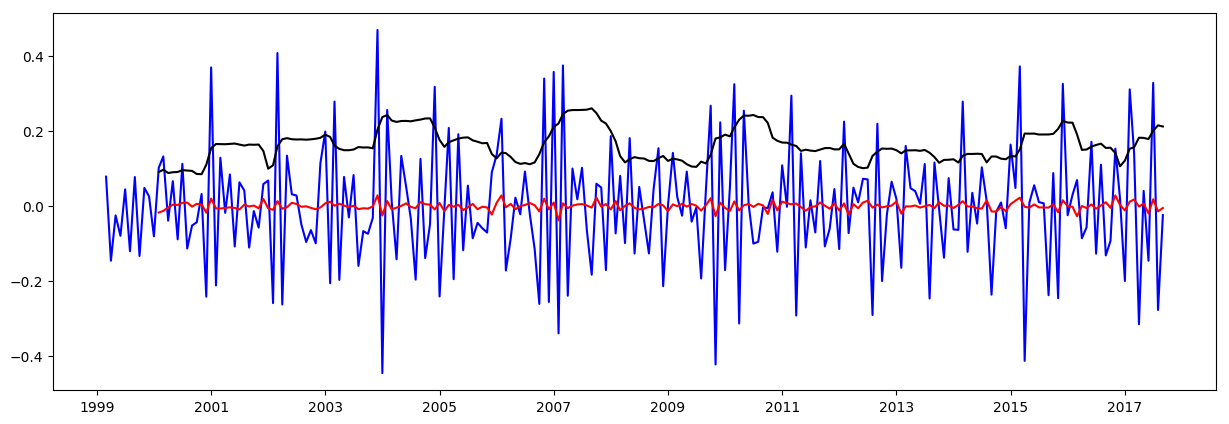

In [42]:
ts_log_dif2 = ts_log_dif1.diff()
ts_log_dif2.dropna(inplace=True)
stationarity_test(ts_log_dif2)

Results of Dickey-Fuller Test:
(-10.166302086159133, 7.2838181445096483e-18, 15, 207, {'10%': -2.5742674398469041, '5%': -2.875606128263243, '1%': -3.4623415245233145}, -300.1792298492727)
Test Statistic                -1.016630e+01
p-value                        7.283818e-18
#Lags Used                     1.500000e+01
Number of Observations Used    2.070000e+02
Critical Value (10%)          -2.574267e+00
Critical Value (5%)           -2.875606e+00
Critical Value (1%)           -3.462342e+00
dtype: float64


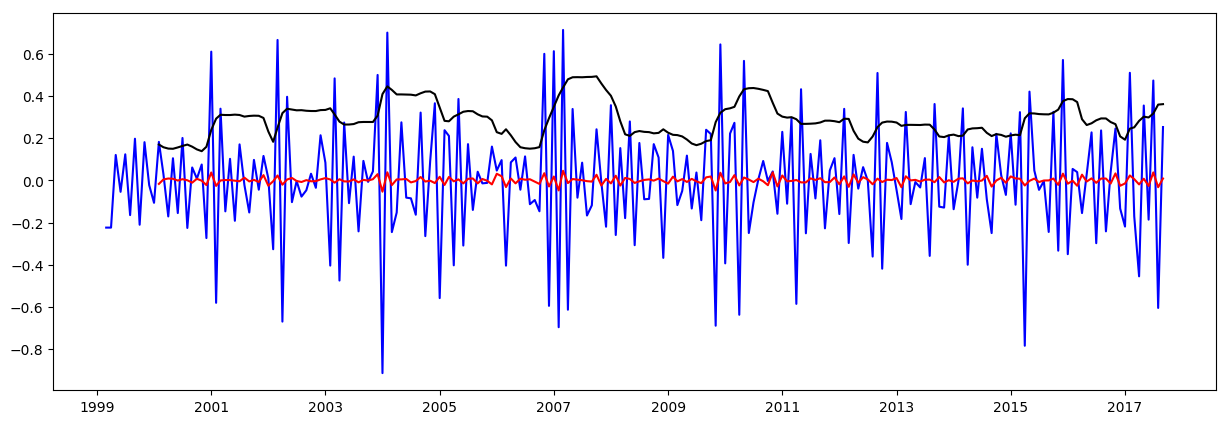

In [43]:
ts_log_dif3 = ts_log_dif2.diff()
ts_log_dif3.fillna(method='bfill', inplace=True)
stationarity_test(ts_log_dif3)

## As we see above, differencing three times exhibits increase of statistics, contrary to expectations. Therefore valid parameter d for ARIMA is 1 or 2. It is not obvious that 2 is worthy, because we do not observe any quadratic trend, moreover, first difference test statistics allready has value les then 1%, therefore we will assume that d-value = 1 is the best choice.

# 3) Валідація двох альтернатив приведення до стаціонарного ряду: decomposition VS differencing;
### As we've allready performed differencing analysys, here just add decomposition example and check result with tests

In [33]:
# TF decompose
from statsmodels.tsa.seasonal import seasonal_decompose

def _decompose(ts, freq):
    decomposition = seasonal_decompose(ts, freq=freq)

    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid

    plt.subplot(411)
    plt.plot(ts, label='Original')
    plt.legend(loc='best')
    plt.subplot(412)
    plt.plot(trend, label='Trend')
    plt.legend(loc='best')
    plt.subplot(413)
    plt.plot(seasonal,label='Seasonality')
    plt.legend(loc='best')
    plt.subplot(414)
    plt.plot(residual, label='Residuals')
    plt.legend(loc='best')
    plt.tight_layout()
    return residual, trend, seasonal

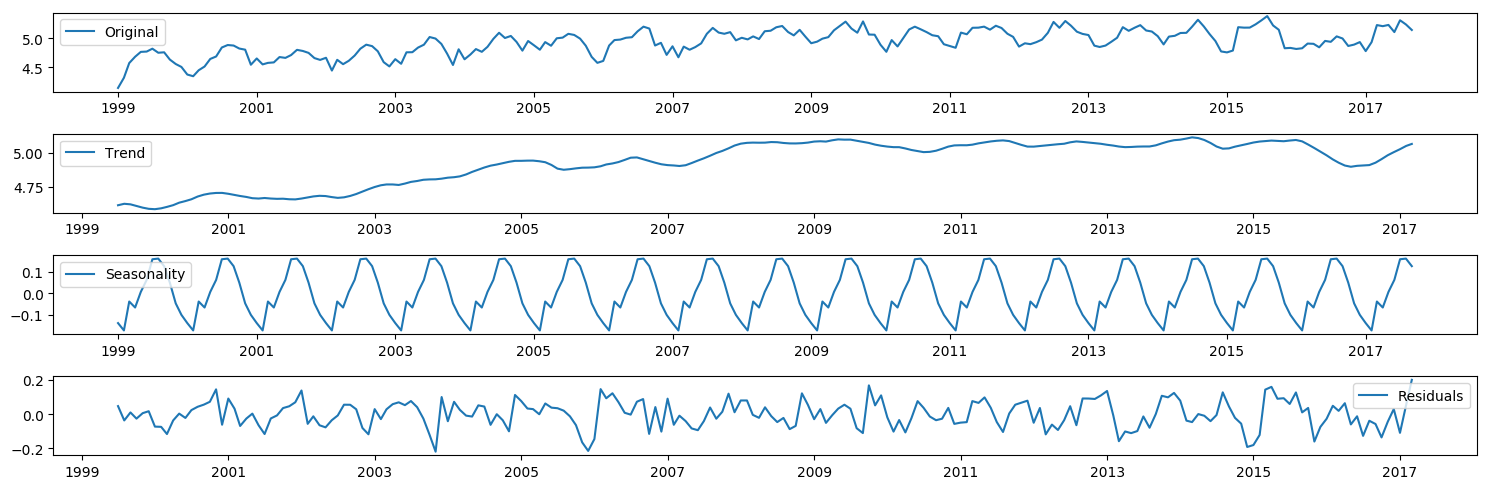

In [34]:
ts_log_decomposed_residuals, ts_log_decomposed_trend, ts_log_decomposed_seasonal = _decompose(ts_log, CYCLE)

In [35]:
ts_log_decomposed_residuals_nandropped = ts_log_decomposed_residuals.dropna(inplace=False)

Results of Dickey-Fuller Test:
(-7.4968166257863569, 4.3576031558712498e-11, 14, 198, {'10%': -2.574611347821651, '5%': -2.8762506321350432, '1%': -3.4638151713286316}, -491.58145510189593)
Test Statistic                -7.496817e+00
p-value                        4.357603e-11
#Lags Used                     1.400000e+01
Number of Observations Used    1.980000e+02
Critical Value (10%)          -2.574611e+00
Critical Value (5%)           -2.876251e+00
Critical Value (1%)           -3.463815e+00
dtype: float64


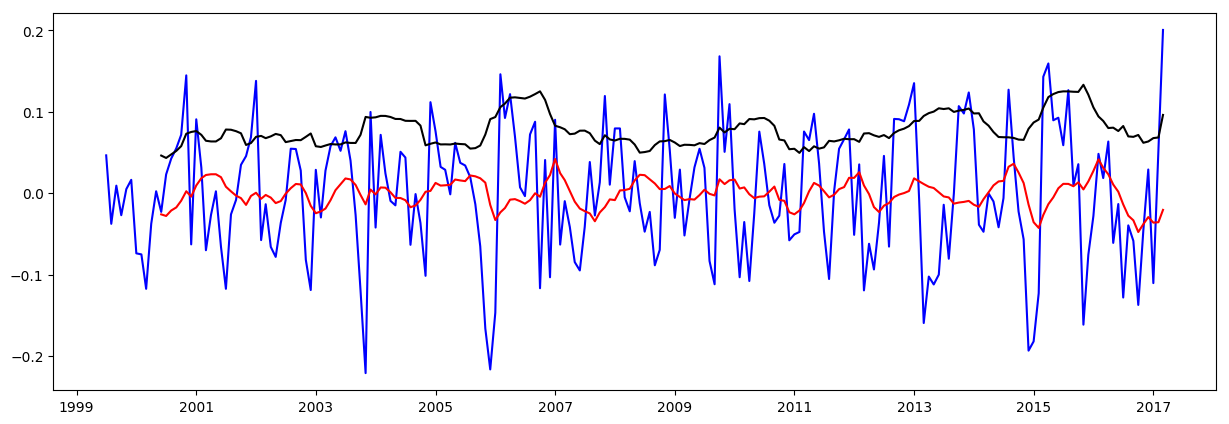

In [44]:
stationarity_test(ts_log_decomposed_residuals_nandropped)

Results of Dickey-Fuller Test:
(-6.1757135995404351, 6.6385185849765202e-08, 11, 212, {'10%': -2.5740891037735847, '5%': -2.8752718989837249, '1%': -3.4615775784078466}, -381.75496846355566)
Test Statistic                -6.175714e+00
p-value                        6.638519e-08
#Lags Used                     1.100000e+01
Number of Observations Used    2.120000e+02
Critical Value (10%)          -2.574089e+00
Critical Value (5%)           -2.875272e+00
Critical Value (1%)           -3.461578e+00
dtype: float64


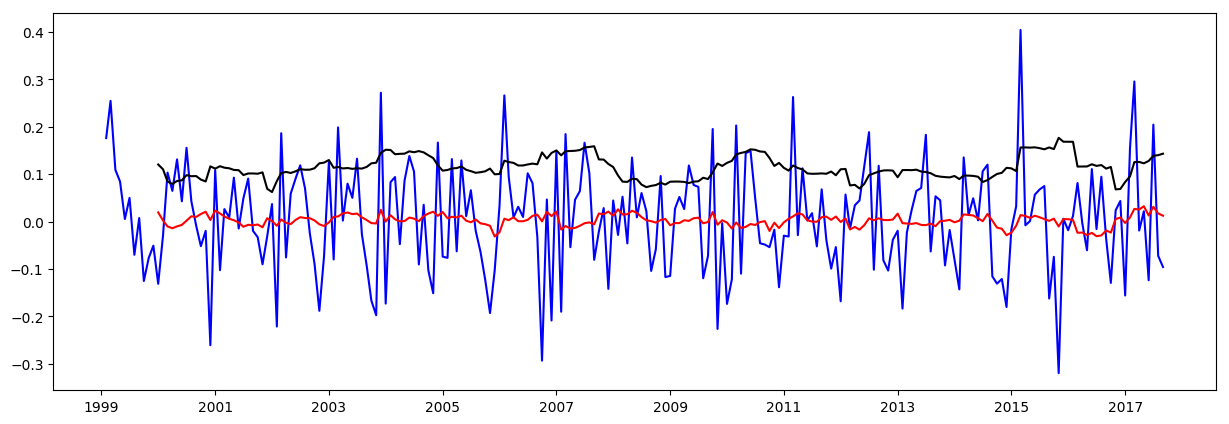

In [46]:
stationarity_test(ts_log_dif1)

## as we observe our 1st difference has lots of hight frequency peaks, in order to smoothen data a little bit we can apply MA-3

Results of Dickey-Fuller Test:
(-5.8729384024212212, 3.2084647777992898e-07, 11, 210, {'10%': -2.574159410430839, '5%': -2.8754036659108091, '1%': -3.4618787358816538}, -812.11017510089346)
Test Statistic                -5.872938e+00
p-value                        3.208465e-07
#Lags Used                     1.100000e+01
Number of Observations Used    2.100000e+02
Critical Value (10%)          -2.574159e+00
Critical Value (5%)           -2.875404e+00
Critical Value (1%)           -3.461879e+00
dtype: float64


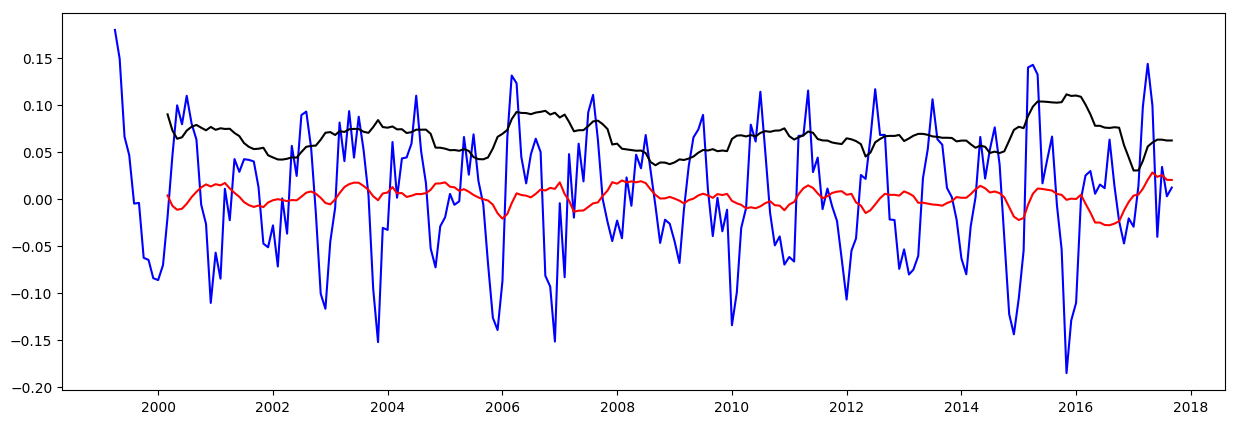

In [57]:
dif_log_1_mean3 = ts_log_dif1.rolling(3).mean()
dif_log_1_mean3.dropna(inplace=True)
stationarity_test(dif_log_1_mean3)

 Mean=[-0.0010961630752086386]   STD= [0.07851163040376279]   PTP = [0.42153262431904953]  <=== decomposed residuals

 Mean=[0.004005184989034117]   STD= [0.0674682751154114]   PTP = [0.365599290718408] < === MA-3 smoothed dif-1 residuals 


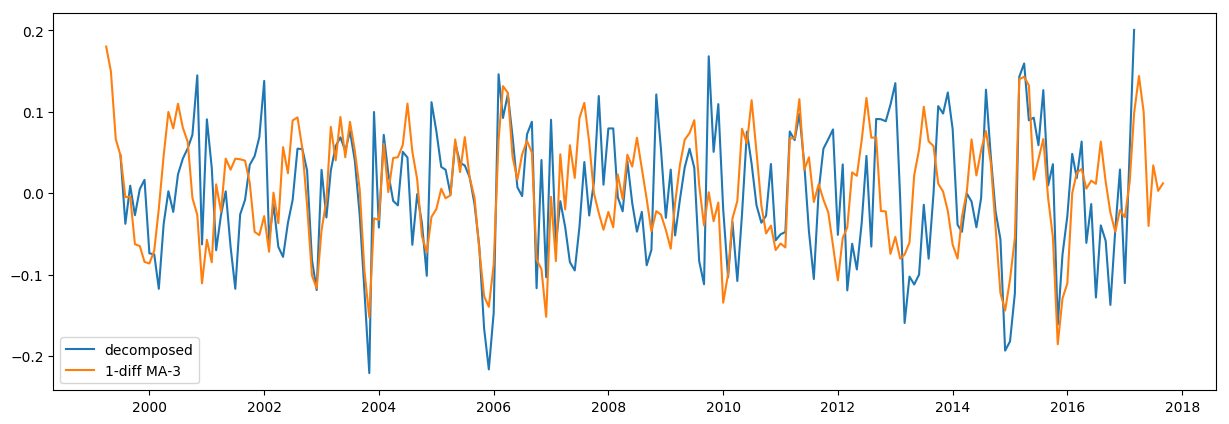

In [63]:
dec, = plt.plot(ts_log_decomposed_residuals_nandropped)
dif, = plt.plot(dif_log_1_mean3)
plt.legend([dec,dif],['decomposed','1-diff MA-3'])
print (" Mean=[{}]   STD= [{}]   PTP = [{}]  <=== decomposed residuals".format( 
    ts_log_decomposed_residuals_nandropped.mean(),
   ts_log_decomposed_residuals_nandropped.std(),
    ts_log_decomposed_residuals_nandropped.ptp())
)
print ()
print (" Mean=[{}]   STD= [{}]   PTP = [{}] < === MA-3 smoothed dif-1 residuals ".format( 
    dif_log_1_mean3.mean(),
   dif_log_1_mean3.std(),
    dif_log_1_mean3.ptp())
)